In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [2]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3
pose_w, pose_h, pose_d = 4,4,36

In [3]:
dataset = np.load('../datasets/car_64.npy')


1553596416


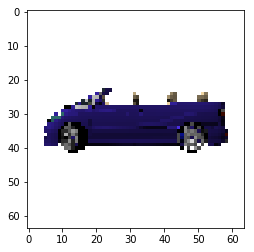

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset
dataset_train.nbytes

1242611712

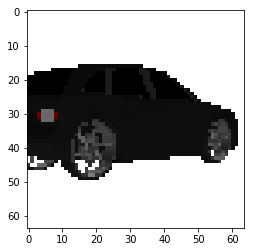

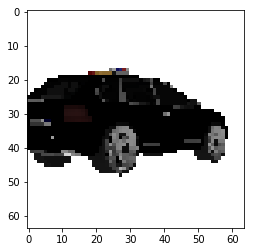

In [8]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [9]:
train_pairs = []
start_pose = [0]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 0, 1)
(1, 0, 1)
(734, 0, 33)
(406, 0, 20)


(1821, 0, 2)
(350, 0, 9)
98315


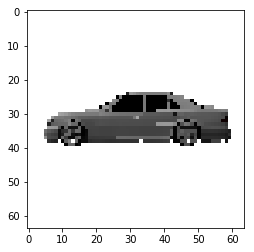

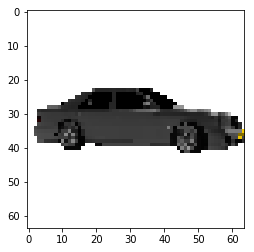

In [11]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(10*36) + 27]
j = dataset_train[(10*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [12]:
def normalize(data):
    data *= 2.0
    data /= 255.0
    data -= 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [13]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

35


In [14]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(pose_w, pose_h, pose_d)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
    pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3) (36, 4, 4, 36)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.float64'>
1.0 -0.992156862745


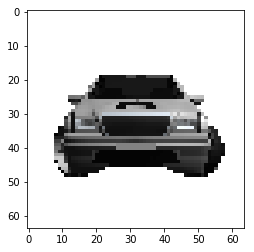

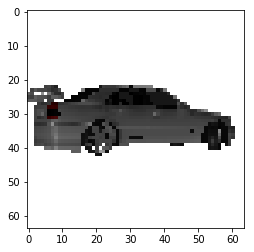

In [15]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 27
print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [16]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         #biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer())
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            #padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer(),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    return tf.reduce_mean(loss)

def local_moment_loss(pred, gt):
    with tf.name_scope('local_moment_loss'):

        ksz, kst = 4, 2
        local_patch = tf.ones((ksz, ksz, 1, 1))
        c = pred.get_shape()[-1]

        # Normalize by kernel size
        pr_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = (pr_var - tf.square(pr_mean)/(ksz**2)) / (ksz ** 2)
        pr_mean = pr_mean / (ksz ** 2)

        gt_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = (gt_var - tf.square(gt_mean)/(ksz**2)) / (ksz ** 2)
        gt_mean = gt_mean / (ksz ** 2)

        # scaling by local patch size
        local_mean_loss = tf.reduce_mean(tf.abs(pr_mean - gt_mean))
        local_var_loss = tf.reduce_mean(tf.abs(pr_var - gt_var))
    return local_mean_loss + local_var_loss
    

In [40]:
tf.reset_default_graph()

In [41]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, pose_w, pose_h, pose_d), name="pose")

In [42]:

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):

    with tf.variable_scope('encoder'):

        _ = conv2d(inputs_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        
        _ = batch_norm(_, True)
        _ = conv2d(_, output=48 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv4",act=lrelu)
        _ = tf.concat([pose_, _], 3)
       

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv1',act=lrelu)
        #_ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ 


In [43]:
global_step = tf.Variable(0,trainable=False)
lr = 5e-4

In [44]:
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(lr, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
res = auto_encoder(inputs_, pose_)
loss_op = l1_loss(res, targets_)

gradients, variables = zip(*optimizer.compute_gradients(loss_op))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
train_op = optimizer.apply_gradients(zip(gradients, variables))


O1 (36, 64, 64, 3)


In [45]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 10
total_images = len(train_pairs)
step = 0

r = total_images // batch_size


for epoch in range(epochs):
    for ii in range(r):
        step += 1
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)
        
        '''
        print(np.min(batch[0]), np.max(batch[0]), "BF")
        plt.imshow(batch[0] / 255)
        plt.show()
        
        batch = normalize(batch)
        batch_labels = normalize(batch_labels)
        
        print(batch[0].shape, batch_labels[0].shape)
        print(np.min(batch[0]), np.max(batch[0]))
        
        plt.imshow(denormalize(batch[0]) / 255)
        plt.show()
        
        plt.imshow(denormalize(batch_labels[0]) / 255)
        plt.show()
        '''

        f_dict = {inputs_: batch, targets_: batch_labels, pose_:pose_labels}
        fetches = [train_op, loss_op]
        _, loss = sess.run(fetches, feed_dict=f_dict)
        if step % 10 == 0:
            print("Epoch: {}/{}...".format(epoch+1, epochs),
            "Training loss: {:.4f}".format(loss))


Epoch: 1/10... Training loss: 0.9118
Epoch: 1/10... Training loss: 0.8395
Epoch: 1/10... Training loss: 0.5767
Epoch: 1/10... Training loss: 0.3558
Epoch: 1/10... Training loss: 0.2939
Epoch: 1/10... Training loss: 0.2422
Epoch: 1/10... Training loss: 0.2061
Epoch: 1/10... Training loss: 0.2408
Epoch: 1/10... Training loss: 0.1980
Epoch: 1/10... Training loss: 0.2152
Epoch: 1/10... Training loss: 0.2113
Epoch: 1/10... Training loss: 0.2042
Epoch: 1/10... Training loss: 0.1712
Epoch: 1/10... Training loss: 0.1778
Epoch: 1/10... Training loss: 0.2134
Epoch: 1/10... Training loss: 0.1710
Epoch: 1/10... Training loss: 0.1841
Epoch: 1/10... Training loss: 0.1896
Epoch: 1/10... Training loss: 0.1968
Epoch: 1/10... Training loss: 0.1930
Epoch: 1/10... Training loss: 0.1774
Epoch: 1/10... Training loss: 0.1621
Epoch: 1/10... Training loss: 0.1995
Epoch: 1/10... Training loss: 0.1926
Epoch: 1/10... Training loss: 0.2017
Epoch: 1/10... Training loss: 0.1876
Epoch: 1/10... Training loss: 0.1522
E

KeyboardInterrupt: 

In [46]:

var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(var_list)
saver.save(sess, 'model/deep_encoder_pose_car')

'model/deep_encoder_pose_car'

In [47]:
d_pairs = test_pairs[5 * batch_size : 6 * batch_size]
test_batch, test_labels, test_pose = get_batch_data(d_pairs, False)
#d_pairs = train_pairs[5 * batch_size : 6 * batch_size]
#test_batch, test_labels, test_pose = get_batch_data(d_pairs, True)

In [48]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([res], feed_dict = feed_dict)

In [49]:
j = 20
op = denormalize(op[0])

In [50]:
#op = op.astype(np.uint8)
print(np.min(op), np.max(op))
#print(np.where(op < -0.00001 ))

#print(op[0][0][59])

0.00018999 255.0


In [51]:
op = np.where(op < 0.0,0.0, op)

In [52]:
print(np.min(op), np.max(op))

0.00018999 255.0


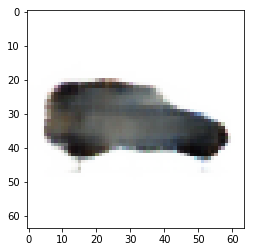

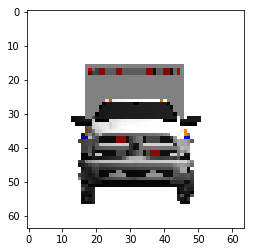

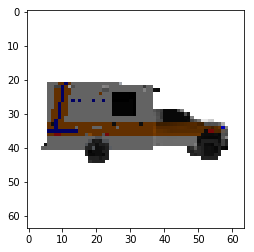

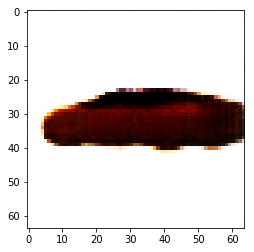

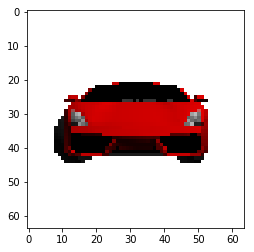

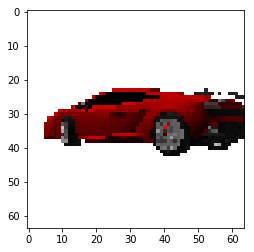

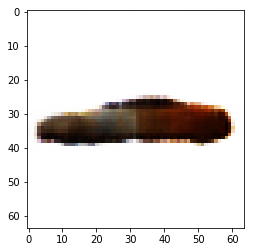

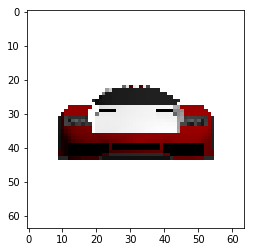

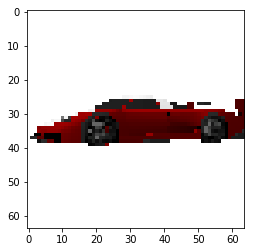

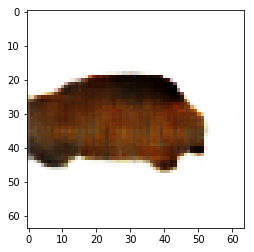

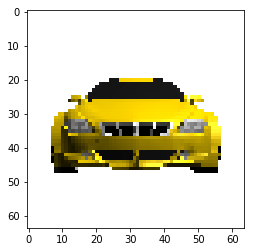

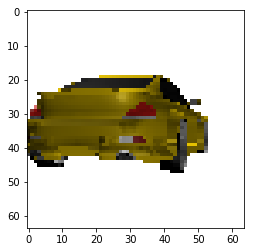

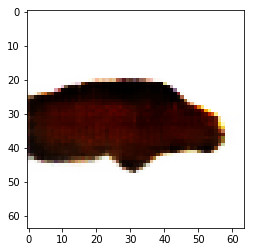

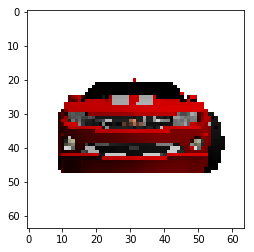

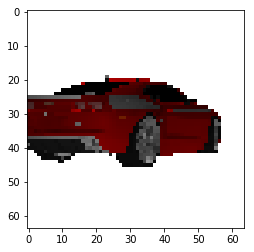

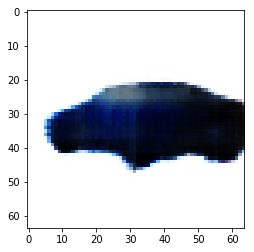

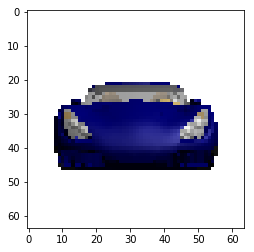

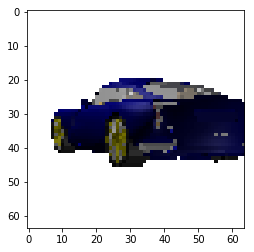

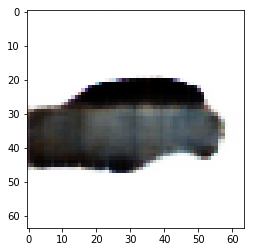

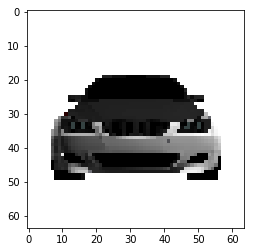

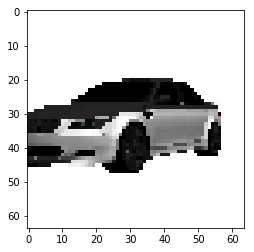

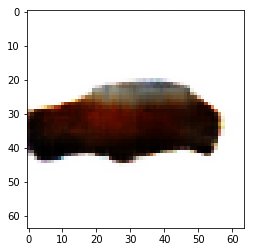

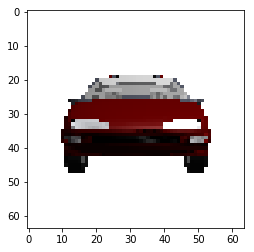

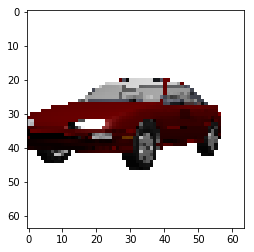

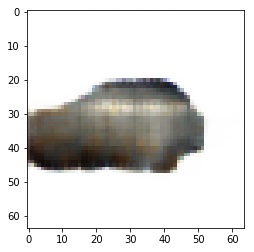

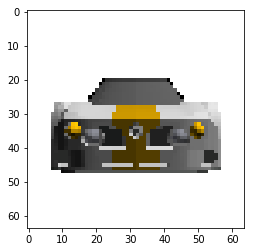

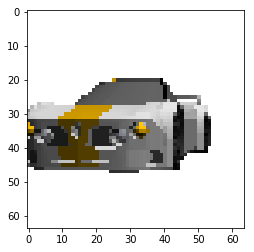

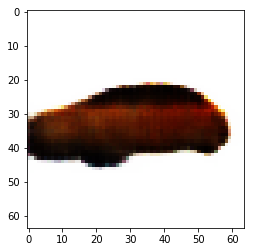

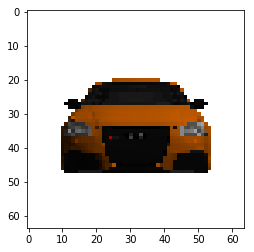

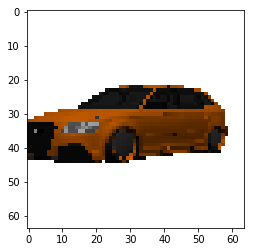

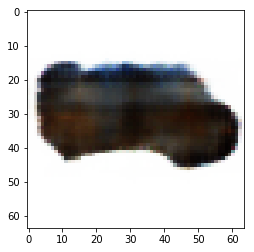

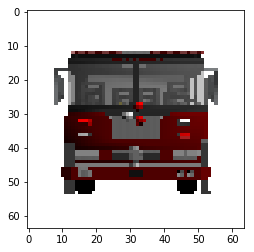

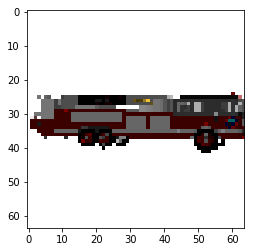

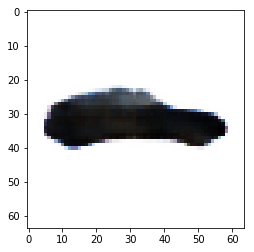

In [ ]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()